### References

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

# Read in raw data, transform and prepare for topic extraction

In [1]:
import numpy as np
import pandas as pd
import regex as re
import json
import sklearn
import eli5
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os.path
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel 
import matplotlib.pyplot as plt

In [3]:
def convert_json_review_to_pd(json_path):
    ''' Takes jason path, reads in all entries, then returns pd dataframe object'''

    # Read in json file
    reviews = []
    with open(json_path) as json_file:
        for rec in json_file:
            dic = json.loads(rec)
            reviews.append(dic)

    # Return pd dataframe object
    reviews_pd = pd.DataFrame.from_records(reviews)
    # reviews_pd['category'] = cat_name

    return reviews_pd


def prepare_text(text):
    '''Cleaning and tokenizing text for analysis'''

    text = str(text)

    # Replace contractions with full text form
    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)

    # Removal of white space
    text = re.sub('\s+', ' ', text)
    # Removal of digits
    text = re.sub(r'\d+', '', text)

    # Convert words to lower case
    text = text.lower()

    # Remove other signs including punctuation
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'\'', ' ', text)

    return text


def remove_stopwords(list_words):
    no_stop_words = [i for i in list_words if not i in stopwords]
    return no_stop_words


def stem_all_words(list_words):
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    stemmed_list = [p_stemmer.stem(i) for i in list_words]
    return stemmed_list


def preprocess(df, cat_name):
    ''' Takes raw pd dataframe object, keeps only rating and star review, then balances set for equal balance
    between 1/2 star reviews and 4/5 star reviews '''

    # Select only subset of columns
    df = df[['overall', 'reviewText']]

    # Remove average ratings (3 stars)
    df = df[df['overall'] != 3]

    # Group poor and strong ratings together (1 and 2 vs 4 and 5)
    df['overall'] = np.where(df['overall'] <= 2, 1, 5)

    # Split low and high scores
    low_scores = df[df['overall'] == 1].reset_index()
    high_scores = df[df['overall'] == 5].reset_index()

    # Select number of rows such that dataset is balanced
    min_rows = min(low_scores.shape[0], high_scores.shape[0]) - 1
    low_scores = low_scores[0:min_rows]
    high_scores = high_scores[0:min_rows]

    # Re-merge low and high scores
    df = low_scores.append(high_scores)

    # Shuffle resulting df
    df = shuffle(df).reset_index()

    # Complete pre-processing step
    df['clean_text'] = list(map(prepare_text, df['reviewText']))
    df['tokenized_words'] = list(map(word_tokenize, df['clean_text']))
    df['tokenized_words'] = list(map(remove_stopwords, df['tokenized_words']))
    df['tokenized_words'] = list(map(stem_all_words, df['tokenized_words']))
    df['category'] = cat_name
    
    df = df[['category', 'overall', 'reviewText', 'clean_text', 'tokenized_words']]

    return df


def append_data_frame(list_dfs):

    ''' Creates one unique df from multipe different product categories'''
    
    # Find size of shortest df, ensure that no df is longer (to ensure balanced claa)
    length_df = []
    for cat in category_df_list:
        length_df.append(cat.shape[0])
    max_rows = np.min(length_df)

    for i in range(0,len(list_dfs)-1):
        if i == 0:
            df = list_dfs[0][0:max_rows]
            df = df.append(list_dfs[1][0:max_rows])
        else:
            df = df.append(list_dfs[i + 1][0:max_rows])
    return df


stopwords = set(stopwords.words('english'))

contractions = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have",
                "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have",
                "didn't": "did not", "doesn't": "does not", "don't": "do not",
                "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
                "haven't": "have not", "he'd": "he would", "he'd've": "he would have",
                "he'll": "he will", "he's": "he is", "how'd": "how did", "how'll": "how will",
                "how's": "how is", "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have",
                "isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is", "let's": "let us",
                "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
                "must've": "must have", "mustn't": "must not", "needn't": "need not", "oughtn't": "ought not",
                "shan't": "shall not", "sha'n't": "shall not", "she'd": "she would", "she'll": "she will",
                "she's": "she is", "should've": "should have", "shouldn't": "should not", "that'd": "that would",
                "that's": "that is", "there'd": "there had", "there's": "there is", "they'd": "they would",
                "they'll": "they will", "they're": "they are", "they've": "they have", "wasn't": "was not",
                "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have",
                "weren't": "were not", "what'll": "what will", "what're": "what are", "what's": "what is",
                "what've": "what have", "where'd": "where did", "where's": "where is", "who'll": "who will",
                "who's": "who is", "won't": "will not", "wouldn't": "would not", "you'd": "you would",
                "you'll": "you will", "you're": "you are"}

In [4]:
# Read reviews data
data_path = '/Users/louisgenereux/Desktop/Term 4/Text_analytics/Amazon reviews/Per product'
musical_instruments = convert_json_review_to_pd(data_path + '/Musical_Instruments.json')
magazine_subscriptions = convert_json_review_to_pd(data_path + '/Magazine_Subscriptions.json')
fashion = convert_json_review_to_pd(data_path + '/AMAZON_FASHION.json')
appliances = convert_json_review_to_pd(data_path + '/Appliances.json')
grocery_and_food = convert_json_review_to_pd(data_path + '/Grocery_and_Gourmet_Food_sub.json')
toys_and_games = convert_json_review_to_pd(data_path + '/Toys_and_Games_sub.json')
print('- Datasets loaded')

# Pre-process data
musical_instruments = preprocess(musical_instruments, 'musical instrument')
magazine_subscriptions = preprocess(magazine_subscriptions, 'magazine subscriptions')
fashion = preprocess(fashion, 'fashion')
appliances = preprocess(appliances, 'appliances')
grocery_and_food = preprocess(grocery_and_food, 'grocery and food')
toys_and_games = preprocess(toys_and_games, 'toy and games')
print('- Text preprocessed')

# Appending all dfs into one aggregated df
category_df_list = [musical_instruments, magazine_subscriptions, fashion, appliances, 
                    grocery_and_food, toys_and_games]
ratings_df = append_data_frame(category_df_list)

- Datasets loaded
- Text preprocessed


In [12]:
ratings_positive = ratings_df[ratings_df['overall']==5]
pd.set_option('max_colwidth', 500)
ratings_positive.head()

,category,overall,reviewText,clean_text,tokenized_words
1,musical instrument,5,Legendary sound and reliability. Always priced the same wherever they are sold.,legendary sound and reliability always priced the same wherever they are sold,"[legendari, sound, reliabl, alway, price, wherev, sold]"
3,musical instrument,5,"It's a great string winder, and it is so nice being able to wind and cut the string with the same tool. It's a brilliant idea haha. It's very good quality, like all planet waves products.",it s a great string winder and it is so nice being able to wind and cut the string with the same tool it s a brilliant idea haha it s very good quality like all planet waves products,"[great, string, winder, nice, abl, wind, cut, string, tool, brilliant, idea, haha, good, qualiti, like, planet, wave, product]"
9,musical instrument,5,Great product shipping was puntual,great product shipping was puntual,"[great, product, ship, puntual]"
13,musical instrument,5,"I use EJ16s on all my acoustics. I love the sound of a new set of strings. Buy them in the 10 back and they are very affordable. They have a decent life span for a non coated string and are the bench mark I use to compare other strings, but I always come back to these. Nice bright clear sound. I got the 3 pack as a gift.",i use ejs on all my acoustics i love the sound of a new set of strings buy them in the back and they are very affordable they have a decent life span for a non coated string and are the bench mark i use to compare other strings but i always come back to these nice bright clear sound i got the pack as a gift,"[use, ej, acoust, love, sound, new, set, string, buy, back, afford, decent, life, span, non, coat, string, bench, mark, use, compar, string, alway, come, back, nice, bright, clear, sound, got, pack, gift]"
19,musical instrument,5,"Basic guitar strap, it works. Just remember to take the picks out of the pocket before you put the guitar down, they will fall out.",basic guitar strap it works just remember to take the picks out of the pocket before you put the guitar down they will fall out,"[basic, guitar, strap, work, rememb, take, pick, pocket, put, guitar, fall]"


# Performing topic extraction

In [6]:
def create_term_dict_and_doc_term_matrix(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [7]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=create_term_dict_and_doc_term_matrix(doc_clean)
    # generate LSA model
    # lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    lsamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [8]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    # for num_topics in range(start, stop, step):
    for number_of_topics in range(start, stop, step):

        # generate LSA model
        # model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [9]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=create_term_dict_and_doc_term_matrix(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    return coherence_values

### Determining how many topics should be used

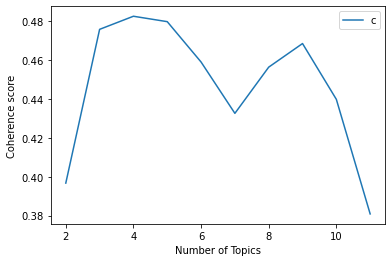

In [13]:
start,stop,step=2,12,1
coherence_values = plot_graph(ratings_positive.tokenized_words,start,stop,step)

### Training a model with the ideal number of topics

In [14]:
# Identifying ideal number of topics
max_score_coherence= np.max(coherence_values)
max_index = coherence_values.index(max_score_coherence)
number_of_topics = max_index + start

In [15]:
# Creating the model
words=10
clean_text=ratings_positive.tokenized_words
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

[(0, '0.050*"game" + 0.024*"play" + 0.019*"fun" + 0.010*"one" + 0.010*"use" + 0.010*"kid" + 0.009*"get" + 0.008*"famili" + 0.008*"make" + 0.008*"like"'), (1, '0.056*"love" + 0.043*"great" + 0.024*"toy" + 0.021*"old" + 0.021*"year" + 0.020*"good" + 0.017*"tea" + 0.015*"play" + 0.014*"son" + 0.014*"product"'), (2, '0.015*"use" + 0.011*"one" + 0.011*"set" + 0.010*"work" + 0.009*"well" + 0.009*"easi" + 0.009*"get" + 0.008*"littl" + 0.008*"old" + 0.007*"put"'), (3, '0.020*"color" + 0.015*"like" + 0.013*"card" + 0.012*"love" + 0.011*"littl" + 0.008*"nice" + 0.008*"would" + 0.008*"one" + 0.008*"size" + 0.007*"perfect"')]


In [16]:
for i,topic in model.show_topics(formatted=True, num_topics=number_of_topics, num_words=20): print(str(i)+": "+ topic)
print()

0: 0.050*"game" + 0.024*"play" + 0.019*"fun" + 0.010*"one" + 0.010*"use" + 0.010*"kid" + 0.009*"get" + 0.008*"famili" + 0.008*"make" + 0.008*"like" + 0.008*"year" + 0.007*"great" + 0.007*"time" + 0.007*"learn" + 0.006*"tast" + 0.006*"enjoy" + 0.005*"love" + 0.005*"even" + 0.005*"also" + 0.005*"lot"
1: 0.056*"love" + 0.043*"great" + 0.024*"toy" + 0.021*"old" + 0.021*"year" + 0.020*"good" + 0.017*"tea" + 0.015*"play" + 0.014*"son" + 0.014*"product" + 0.013*"daughter" + 0.013*"gift" + 0.012*"bought" + 0.012*"price" + 0.011*"one" + 0.011*"kid" + 0.010*"time" + 0.010*"purchas" + 0.009*"christma" + 0.008*"buy"
2: 0.015*"use" + 0.011*"one" + 0.011*"set" + 0.010*"work" + 0.009*"well" + 0.009*"easi" + 0.009*"get" + 0.008*"littl" + 0.008*"old" + 0.007*"put" + 0.006*"like" + 0.006*"piec" + 0.006*"would" + 0.006*"around" + 0.006*"time" + 0.005*"push" + 0.005*"need" + 0.005*"go" + 0.005*"good" + 0.005*"togeth"
3: 0.020*"color" + 0.015*"like" + 0.013*"card" + 0.012*"love" + 0.011*"littl" + 0.008*"ni

### Assigning topic to each text review

In [17]:
dictionary,doc_term_matrix = create_term_dict_and_doc_term_matrix(ratings_positive.tokenized_words)

In [18]:
def score_review_for_topic(model_object, doc_term_matrix_entry):
    '''Takes doc term matrix entry, returns the score for each topic'''
    
    score_list = model_object[doc_term_matrix_entry]
    
    return score_list

In [19]:
def identify_topic(topic_scoring_list):
    '''returns topic and score, for a specific list of (topic_number, score) entry corresponding to one text review'''
    
    # Finding topic with the highest score
    list_scores = []
    for topic_score in topic_scoring_list:
        score_string = str(topic_score).split(', ')[1]
        list_scores.append(float(score_string[:(len(score_string)-1)]))
    max_score = np.max(list_scores)
    
    # Finding the index of the topic with the highest score
    max_index = list_scores.index(max_score)
    
    return max_index

In [20]:
score_for_each_topic = [score_review_for_topic(model, i) for i in doc_term_matrix[:]]

In [21]:
main_topic = list(map(identify_topic, score_for_each_topic))

In [22]:
ratings_positive['topic_scores'] = score_for_each_topic
ratings_positive['main_topic'] = main_topic
ratings_positive.head()

,category,overall,reviewText,clean_text,tokenized_words,topic_scores,main_topic
1,musical instrument,5,Legendary sound and reliability. Always priced the same wherever they are sold.,legendary sound and reliability always priced the same wherever they are sold,"[legendari, sound, reliabl, alway, price, wherev, sold]","[(0, 0.034340188), (1, 0.59405357), (2, 0.15533085), (3, 0.21627541)]",1
3,musical instrument,5,"It's a great string winder, and it is so nice being able to wind and cut the string with the same tool. It's a brilliant idea haha. It's very good quality, like all planet waves products.",it s a great string winder and it is so nice being able to wind and cut the string with the same tool it s a brilliant idea haha it s very good quality like all planet waves products,"[great, string, winder, nice, abl, wind, cut, string, tool, brilliant, idea, haha, good, qualiti, like, planet, wave, product]","[(0, 0.28725424), (1, 0.44099405), (2, 0.25725982), (3, 0.014491884)]",1
9,musical instrument,5,Great product shipping was puntual,great product shipping was puntual,"[great, product, ship, puntual]","[(0, 0.060373425), (1, 0.818597), (2, 0.060509603), (3, 0.060519993)]",1
13,musical instrument,5,"I use EJ16s on all my acoustics. I love the sound of a new set of strings. Buy them in the 10 back and they are very affordable. They have a decent life span for a non coated string and are the bench mark I use to compare other strings, but I always come back to these. Nice bright clear sound. I got the 3 pack as a gift.",i use ejs on all my acoustics i love the sound of a new set of strings buy them in the back and they are very affordable they have a decent life span for a non coated string and are the bench mark i use to compare other strings but i always come back to these nice bright clear sound i got the pack as a gift,"[use, ej, acoust, love, sound, new, set, string, buy, back, afford, decent, life, span, non, coat, string, bench, mark, use, compar, string, alway, come, back, nice, bright, clear, sound, got, pack, gift]","[(0, 0.12565266), (1, 0.4021218), (2, 0.2667203), (3, 0.20550519)]",1
19,musical instrument,5,"Basic guitar strap, it works. Just remember to take the picks out of the pocket before you put the guitar down, they will fall out.",basic guitar strap it works just remember to take the picks out of the pocket before you put the guitar down they will fall out,"[basic, guitar, strap, work, rememb, take, pick, pocket, put, guitar, fall]","[(0, 0.022490714), (1, 0.022407146), (2, 0.32849774), (3, 0.6266044)]",3


### Creating summary and visualizing

##### Frequency of each topic

In [23]:
topic_summary = pd.pivot_table(ratings_positive, values=['clean_text'] ,index=['category'],
                    columns=['main_topic'], aggfunc='count')

##### Relative frequency of each topic per category

In [24]:
topic_summary_pct = topic_summary.div(topic_summary.sum(axis=1), axis=0)
topic_summary_pct = topic_summary_pct.droplevel(level=0, axis=1)
topic_summary_pct

main_topic,0,1,2,3
category,,,,
appliances,0.150235,0.388743,0.362798,0.098224
fashion,0.041485,0.380378,0.232104,0.346033
grocery and food,0.434159,0.384972,0.044429,0.136439
magazine subscriptions,0.707526,0.243062,0.021045,0.028367
musical instrument,0.122612,0.461429,0.302526,0.113432
toy and games,0.372379,0.397001,0.150110,0.080510


In [25]:
def plot_sns_heatmap(df):

    sns.set()

    fig, ax1 = matplotlib.pyplot.subplots(figsize=(20,10))
    ax2 = sns.heatmap(df,
                     #annot=True,
                     cmap="YlGnBu", cbar=True)
    ax2.set_xticklabels(ax2.get_xmajorticklabels(),
                        #fontsize = 12,
                        rotation=360)
    ax2.set(title='Frequency of document topics across categories')
    ax2.set(xlabel='Topic number')
    ax2.set(ylabel='Product category')

    sns.set(font_scale=1.3)
    # return ax2
    fig.data = df

    plt.show()

##### Visualization

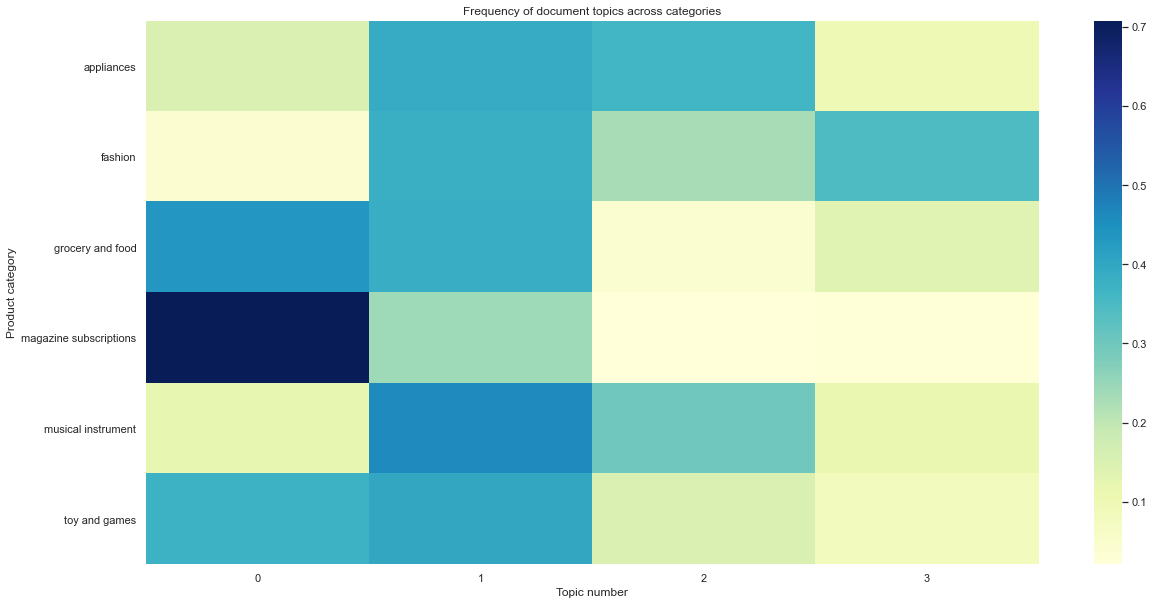

In [26]:
plot_sns_heatmap(topic_summary_pct)